### Bibliotecas

In [2]:
import pandas as pd
from datetime import datetime, date
from matplotlib import pyplot as plt
from scipy import stats
from patsy import dmatrices
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Importação dos Dados e Criação de Variáveis

In [4]:
dataset_dados = pd.read_excel('botafogo_previsao_estadio.xlsx')

In [5]:
dataset_resultados = pd.read_excel('botafogo_valores_previstos.xlsx')

In [6]:
index_novo = len(dataset_resultados)

In [7]:
dataset_dados = dataset_dados.sort_values(by='data').reset_index(drop=True)

##### Datas

In [9]:
dataset_dados['data'] = pd.to_datetime(dataset_dados['data'])

In [10]:
dataset_dados['horario'] = dataset_dados['horario'].fillna('99:99:99')

In [11]:
dataset_dados = dataset_dados.assign(dia_semana=dataset_dados['data'].dt.weekday, hora=dataset_dados['horario'].astype('str').str.slice(stop=2).astype('int').replace({99:np.nan}),
                     minuto=dataset_dados['horario'].astype('str').str.slice(start=3, stop=5).astype('int').replace({99:np.nan}))
dataset_dados['horario'] = dataset_dados['horario'].replace({'99:99:99':np.nan})

In [12]:
dataset_dados['mes'] = dataset_dados['data'].dt.month

In [13]:
dataset_dados['dia_mes'] = dataset_dados['data'].dt.day

##### Resultados de Jogos

In [15]:
dataset_dados['resultado_temporario'] = dataset_dados['gols_mandante'] - dataset_dados['gols_visitantes']

In [16]:
dataset_dados = dataset_dados.assign(resultado_partida=dataset_dados['resultado_temporario'].map(lambda x: 0 if x == 0 else 1 if x > 0 else -1))

In [17]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == 1)
].index, 'resultado_partida'] = -1

In [18]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == -1)
].index, 'resultado_partida'] = 1

Resultados Consecutivos

    Olhando para os últimos 5 jogos como vem sendo o "momento" do time:
        Vitória: 1 ponto
        Empate: 0 ponto
        Derrota: -1 ponto
        
    Valor Máximo: 5 pontos
    Valor Mínimo: -5 pontos

In [20]:
#RESULTADOS CONSECUTIVOS

dataset_consec = dataset_dados['resultado_partida'].shift(5, fill_value=0)

for i in range(len(dataset_dados)):
    valor = dataset_consec[i:5+i].sum()
    dataset_dados.loc[i, 'resultados_consecutivos'] = valor
    
#RESULTADO ÚLTIMO JOGO

dataset_ultimo = dataset_dados['resultado_partida'].shift(1, fill_value=0)

for i in range(len(dataset_dados)):
    valor = dataset_ultimo[i:5+i].sum()
    dataset_dados.loc[i, 'resultados_ultimo_jogo'] = valor

del dataset_consec, dataset_ultimo

##### Gols, Colocação e Time Adversário

In [22]:
dataset_dados.loc[:,['gols_botafogo','colocacao_botafogo','colocacao_adversario','time_adversario']] = dataset_dados.apply(lambda d: d[['gols_mandante','colocacao_mandante','colocacao_visitante','time_visitante']].rename(index={'gols_mandante':'gols_botafogo','colocacao_mandante':'colocacao_botafogo','colocacao_visitante':'colocacao_adversario','time_visitante':'time_adversario'})
                            if d['time_mandante'] == 'Botafogo' 
                            else d[['gols_visitantes','colocacao_visitante','colocacao_mandante','time_mandante']].rename(index={'gols_visitantes':'gols_botafogo','colocacao_visitante':'colocacao_botafogo','colocacao_mandante':'colocacao_adversario','time_mandante':'time_adversario'}), axis=1)

In [23]:
dataset_gols = dataset_dados['gols_botafogo'].shift(5, fill_value=0)
for i in range(len(dataset_dados)):
    valor = dataset_gols[i+0:5+i].sum()
    dataset_dados.loc[i, 'gols_botafogo_ultimos_jogos'] = valor
del dataset_gols

##### Percentual de Ocupacao

In [25]:
dataset_dados['percentual_ocupacao'] = round((dataset_dados['publico'] / dataset_dados['publico_max']) * 100, 2)

##### Jogos de Mando Vendido ou Compartilhado

In [27]:
dados_mando_vendido = dataset_dados[(dataset_dados['resultado_financeiro'] != dataset_dados['custo_botafogo'])]
index = dados_mando_vendido[~dados_mando_vendido['custo_botafogo'].isnull()].index

In [28]:
dataset_dados['mando_vendido_compartilhado'] = False
dataset_dados.loc[index, 'mando_vendido_compartilhado'] = True

##### Prejuízo ou Lucro

In [30]:
index = dataset_dados[dataset_dados['custo_botafogo'] <= 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[dataset_dados['custo_botafogo'] > 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

Competições Internacionais não possuem o borderô publicado a partir de certa data, portanto vamos considerar uma regra:

    Nunca houve prejuízo em jogos com 900000 reais de arrecadação

In [32]:
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] < 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] >= 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

### Dados Usáveis para o Modelo e Tratamentos

In [34]:
dataset_dados = dataset_dados[dataset_dados['time_mandante'] == 'Botafogo']
dataset_dados = dataset_dados.reset_index(drop=True)

##### Distância dos Dias entre o Último Jogo em Casa

In [36]:
dataset_dados['data_ultimo_jogo'] = dataset_dados['data'].shift(1)

In [37]:
dataset_dados.loc[0,'data_ultimo_jogo'] = pd.to_datetime('2022-03-07')

In [38]:
dataset_dados.loc[:, 'dias_ultimo_jogo_casa'] = (dataset_dados['data'] - dataset_dados['data_ultimo_jogo']).dt.days

##### Tratamentos

In [40]:
len(dataset_dados)

126

In [41]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data', 'horario',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida', 'publico',
       'publico_max', 'arrecadacao', 'despesas', 'impostos',
       'resultado_financeiro', 'custo_botafogo', 'anunciou_poupar',
       'time_mandante', 'time_visitante', 'estado_adversario', 'classico',
       'eliminatorio', 'tecnico_botafogo', 'desfalques', 'colocacao_mandante',
       'colocacao_visitante', 'gols_mandante', 'gols_visitantes', 'dia_semana',
       'hora', 'minuto', 'mes', 'dia_mes', 'resultado_temporario',
       'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'gols_botafogo', 'colocacao_botafogo',
       'colocacao_adversario', 'time_adversario',
       'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro', 'data_ultimo_jogo',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [42]:
index_coleta = dataset_dados[dataset_dados['gols_mandante'].isna()==True].index[0]

In [43]:
dataset_resultados.loc[index_novo,'ano_campeonato'] = dataset_dados['ano_campeonato'][index_coleta]
dataset_resultados.loc[index_novo,'campeonato'] = dataset_dados['campeonato'][index_coleta]
dataset_resultados.loc[index_novo,'fase'] = dataset_dados['fase'][index_coleta]
dataset_resultados.loc[index_novo,'data'] = dataset_dados['data'][index_coleta]
dataset_resultados.loc[index_novo,'time_mandante'] = dataset_dados['time_mandante'][index_coleta]
dataset_resultados.loc[index_novo,'time_visitante'] = dataset_dados['time_visitante'][index_coleta]

In [44]:
dataset_resultados

,ano_campeonato,campeonato,fase,data,time_mandante,time_visitante,previsão_ocupacao,score_modelo_1,rmse,mae,...,score_modelo_2,acurácia_modelo_2,prejuizo_lucro,previsão_resultado_partida,score_modelo_3,acurácia_modelo_3,resultado_partida,modelo_1,modelo_2,modelo_3
0,2024.0,libertadores,fase de grupos,2024-04-03,Botafogo,Junior Barranquilla,44.06822,68.2,17.678700,14.642900,...,53.7,0.43,1.0,2.0,81.4,0.64,2.0,NaN,NaN,NaN
1,2024.0,serie a,liga,2024-04-18,Botafogo,Atlético-GO,58.73819,79.9,16.328600,14.040000,...,56.4,0.36,0.0,1.0,85.5,0.57,1.0,NaN,NaN,NaN
2,2024.0,serie a,liga,2024-04-22,Botafogo,Juventude,41.46651,60.7,20.349400,18.115000,...,53.6,0.43,0.0,1.0,82.1,0.64,1.0,NaN,NaN,NaN
3,2024.0,libertadores,fase de grupos,2024-04-24,Botafogo,Universitario-PER,45.54880,72.9,17.321600,15.208700,...,55.4,0.33,1.0,1.0,83.9,0.40,1.0,NaN,NaN,NaN
4,2024.0,copa do brasil,terceira fase,2024-05-02,Botafogo,Vitória,60.61654,75.4,19.423300,16.566600,...,71.9,0.73,0.0,1.0,78.9,0.60,1.0,NaN,NaN,NaN
5,2024.0,serie a,liga,2024-05-06,Botafogo,EC Bahia,48.57735,50.3,20.175000,17.729300,...,74.1,0.40,1.0,1.0,81.0,0.60,2.0,NaN,NaN,NaN
6,2024.0,libertadores,fase de grupos,2024-05-08,Botafogo,LDU,49.19577,52.7,20.120400,17.044000,...,79.7,0.53,1.0,2.0,69.4,0.67,1.0,NaN,NaN,NaN
7,2024.0,serie a,liga,2024-06-11,Botafogo,Fluminense,55.47233,66.3,18.116200,15.564000,...,53.3,0.47,1.0,2.0,70.0,0.70,1.0,NaN,NaN,NaN
8,2024.0,serie a,liga,2024-06-19,Botafogo,Athletico-PR,61.27132,83.0,16.632400,14.323100,...,53.3,0.50,0.0,2.0,83.3,0.88,0.0,NaN,NaN,NaN
9,2024.0,serie a,liga,2024-06-26,Botafogo,RB Bragantino,56.84138,81.1,18.038700,15.005600,...,65.6,0.88,0.0,0.0,72.1,0.69,1.0,NaN,NaN,NaN


In [45]:
dataset_dados = dataset_dados.drop(columns=['resultado_temporario', 'gols_visitantes', 'gols_mandante',
                                           'colocacao_visitante', 'colocacao_mandante', 'time_visitante', 'time_mandante',
                                           'custo_botafogo', 'resultado_financeiro', 'impostos', 'despesas', 'arrecadacao',
                                            'publico_max', 'publico', 'gols_botafogo', 'horario', 'data_ultimo_jogo', 'tecnico_botafogo'])

In [46]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida',
       'anunciou_poupar', 'estado_adversario', 'classico', 'eliminatorio',
       'desfalques', 'dia_semana', 'hora', 'minuto', 'mes', 'dia_mes',
       'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'colocacao_botafogo', 'colocacao_adversario',
       'time_adversario', 'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [47]:
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'] == 'SIM'].index, 'anunciou_poupar'] = True
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'].isnull()].index, 'anunciou_poupar'] = False
dataset_dados.loc[dataset_dados[dataset_dados['classico'] == 'SIM'].index, 'classico'] = True
dataset_dados.loc[dataset_dados[dataset_dados['classico'].isnull()].index, 'classico'] = False
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'] == 'SIM'].index, 'eliminatorio'] = True
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'].isnull()].index, 'eliminatorio'] = False

In [48]:
len(dataset_dados.columns)

30

In [49]:
dataset_dados = pd.get_dummies(dataset_dados, columns=['campeonato', 'estádio', 'tipo_partida', 'estado_adversario', 'time_adversario', 'fase'])

In [50]:
dataset_dados = dataset_dados.astype({'anunciou_poupar': bool,
                                      'classico': bool,
                                      'eliminatorio': bool,
                                       'prejuizo_lucro': bool
                                     })

In [51]:
dataset_previsao = dataset_dados[dataset_dados['data'] >= pd.to_datetime(date.today())]
dataset_dados = dataset_dados[dataset_dados['data'] < pd.to_datetime(date.today())]
dataset_dados = dataset_dados.drop(columns=['data'])
dataset_previsao = dataset_previsao.drop(columns=['data'])
dataset_dados = dataset_dados.reset_index(drop=True)

In [52]:
len(dataset_dados)

105

##### Normalizações com Substituição por IQR e Box-Cox

In [54]:
listaColunas = ['ano_campeonato', 'temperatura', 'jogos_no_mes', 'rodada', 'desfalques', 'dia_semana', 'hora', 'mes', 'dia_mes', 'colocacao_botafogo',
                'colocacao_adversario', 'gols_botafogo_ultimos_jogos', 'dias_ultimo_jogo_casa']

In [55]:
for i in listaColunas:
    
    if stats.shapiro(dataset_dados[i])[1] < 0.05:
    
        quartilUm = np.percentile(dataset_dados[i], 25)
        quartilTres = np.percentile(dataset_dados[i], 75)
        iqr = (quartilTres - quartilUm) * 1.5
        lim_superior = quartilTres + iqr
        lim_inferior = quartilUm - iqr
        
        dataset_dados.loc[dataset_dados[dataset_dados[i] > lim_superior].index, i] = lim_superior
        dataset_dados.loc[dataset_dados[dataset_dados[i] < lim_inferior].index, i] = lim_inferior
    
        if stats.shapiro(dataset_dados[i])[1] < 0.05:

            dataset_dados.loc[dataset_dados[dataset_dados[i] <= 0].index, i] = 0.0000001
            dataset_dados[i] = stats.boxcox(dataset_dados[i])[0]

##### Min Max Scaler

In [57]:
for i in listaColunas:
    scaler = MinMaxScaler()
    dataset_dados[i] = scaler.fit_transform(dataset_dados[[i]])

In [58]:
dataset_dados.to_csv('dados_modelo_final.csv', index=False)

### Datasets Modelos

Haverão Três Modelos, cada um olhando para uma variável alvo específica, as variáveis alvo serão:

    - percentual_ocupacao: Olhando para tentarmos prever a quantidade de pessoas que irão aos jogos
    - prejuizo_lucro: Olhando para tentarmos prever se o jogo foi rentável (olhando apenas para o contexto do jogo)
    - resultado_partida: Olhando para tentarmos prever o resultado do jogo (Derrota, Vitória ou Empate
    
Sendo assim cada modelo terá seu dataset específico, pois as variáveis alvo não são passíveis de serem utilizadas nos modelos que não sejam os seus por não serem valores disponíveis para a previsão antes do evento acontecer, chamaremos essas varíaveis de indisponíveis.

In [61]:
dados_modelo_percentual_ocupacao = dataset_dados.drop(columns=['prejuizo_lucro', 'resultado_partida']).copy()
dados_modelo_prejuizo_lucro = dataset_dados.drop(columns=['percentual_ocupacao', 'resultado_partida']).copy()
dados_modelo_resultado_partida = dataset_dados.drop(columns=['percentual_ocupacao', 'prejuizo_lucro']).copy()

### Análise Exploratória

##### Funções Úteis

In [64]:
def concentracao_valores (dados, coluna):
    if len(dados[coluna].unique()) > 3:        
        print(dados[coluna].describe())
    else:        
        print(dados[coluna].value_counts())

In [65]:
def correlacao_modelos (dados, coluna):
    print('Menores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values().head(7))
    print('======================')
    print('Maiores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values(ascending=False).head(7))

In [66]:
def visualizacoes (dados, coluna, label):
    if len(dados[coluna].unique()) > 3: 
        fig, ax = plt.subplots()
        ax.hist(dados[coluna])
        ax.set_xlabel(label)
        ax.set_title('Análise Visual - Histograma - '+label)
        plt.show()

In [67]:
def taxas_erro (valores_reais, valores_previstos):
    #RMSE
    rmse = sqrt(mean_squared_error(valores_reais, valores_previstos))
    print('Erro médio quadrático: ', rmse)
    #MAE
    mae = mean_absolute_error(valores_reais, valores_previstos)
    print('Erro médio absoluto: ', mae)
    return rmse, mae

Esse artigo me ajudou com a tunagem dos hiperparâmetros:

    - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [69]:
def tunning_hiperpametros_xgboost (modelo, X_train, y_train):

    parametros = list()
    
    print('Testando Variáveis: max_depth, min_child_weight')
    
    param_test = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2),
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
        
    max_depth = gsearch.best_params_['max_depth']
    min_child_weight = gsearch.best_params_['min_child_weight']
    parametros.append(max_depth)
    parametros.append(min_child_weight)
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  
    
    print('Testando Variáveis:gamma')
    
    param_test = {
     'gamma':[i/10.0 for i in range(0,5)],
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = 0 , subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    gamma = gsearch.best_params_['gamma']
    parametros.append(gamma)
    
    print('-----------------------------')  
    
    print('Testando Variáveis: subsample, colsample_bytree')
    
    param_test = {
     'subsample':[i/10.0 for i in range(6,10)],
     'colsample_bytree':[i/10.0 for i in range(6,10)]
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = gamma, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    parametros.append(gsearch.best_params_['subsample'])
    parametros.append(gsearch.best_params_['colsample_bytree'])
    
    print('-----------------------------')  
    
    print('Testando Variáveis: reg_alpha')
    
    param_test = {
     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = gamma, subsample = gsearch.best_params_['subsample'],
                    colsample_bytree = gsearch.best_params_['colsample_bytree'], scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    parametros.append(gsearch.best_params_['reg_alpha'])
    
    print('-----------------------------')  

    return parametros

In [70]:
def tunning_hiperpametros_catboost(modelo, X_train, y_train):


    parametros = list()
    def grid_search(param_grid, estimator, X_train, y_train):
        gsearch = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                               scoring='roc_auc', n_jobs=-1, cv=10)
        gsearch.fit(X_train, y_train)
        return gsearch.best_params_

    modelo_base = modelo(learning_rate=0.01, random_state=1, cat_features=[], verbose=False)

    print('Testando Variáveis: depth, min_data_in_leaf')
    param_test = {
        'depth': [3, 5, 7, 9],
        'min_data_in_leaf': [1, 5, 10]
    }
    best_params_depth = grid_search(param_test, modelo_base, X_train, y_train)
    parametros.append(best_params_depth['depth'])
    parametros.append(best_params_depth['min_data_in_leaf'])
    print('Melhores valores para depth e min_data_in_leaf: ', best_params_depth)
    

    print('Testando Variáveis: learning_rate, iterations')
    param_test = {
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 200, 300]
    }
    modelo_base.depth = best_params_depth['depth']
    modelo_base.min_data_in_leaf = best_params_depth['min_data_in_leaf']
    best_params_lr_iter = grid_search(param_test, modelo_base, X_train, y_train)
    parametros.append(best_params_lr_iter['iterations'])
    parametros.append(best_params_lr_iter['learning_rate'])
    print('Melhores valores para learning_rate e iterations: ', best_params_lr_iter)

    print('Testando Variáveis: subsample, colsample_bylevel')
    param_test = {
        'subsample': [i/10.0 for i in range(6,10)],
        'colsample_bylevel': [i/10.0 for i in range(6,10)]
    }
    modelo_base.learning_rate = best_params_lr_iter['learning_rate']
    modelo_base.iterations = best_params_lr_iter['iterations']
    best_params_subsample = grid_search(param_test, modelo_base, X_train, y_train)
    parametros.append(best_params_subsample['colsample_bylevel'])
    parametros.append(best_params_subsample['subsample'])
    print('Melhores valores para subsample e colsample_bylevel: ', best_params_subsample)

    print('-----------------------------')

    return parametros

##### Modelo 1

In [72]:
concentracao_valores(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

count    105.000000
mean      46.898190
std       25.259118
min        5.190000
25%       26.060000
50%       45.990000
75%       69.390000
max       91.780000
Name: percentual_ocupacao, dtype: float64


In [73]:
correlacao_modelos(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

Menores Valores
----------------------
campeonato_carioca              -0.596498
estado_adversario_RJ            -0.412199
anunciou_poupar                 -0.389254
temperatura                     -0.347796
time_adversario_Portuguesa-RJ   -0.303482
mando_vendido_compartilhado     -0.289359
estádio_Raulino de Oliveira     -0.212514
Name: percentual_ocupacao, dtype: float64
Maiores Valores
----------------------
percentual_ocupacao          1.000000
mes                          0.581935
campeonato_serie a           0.368488
rodada                       0.309028
campeonato_libertadores      0.275354
estado_adversario_SP         0.208808
time_adversario_Palmeiras    0.176432
Name: percentual_ocupacao, dtype: float64


In [74]:
dados_modelo_percentual_ocupacao.corr()['percentual_ocupacao']

ano_campeonato                     NaN
temperatura                  -0.347796
jogos_no_mes                 -0.127372
rodada                        0.309028
anunciou_poupar              -0.389254
                                ...   
fase_segunda fase            -0.084537
fase_semi-final               0.043635
fase_semi-final - taça rio   -0.204975
fase_terceira fase           -0.024131
fase_unico                   -0.125323
Name: percentual_ocupacao, Length: 129, dtype: float64

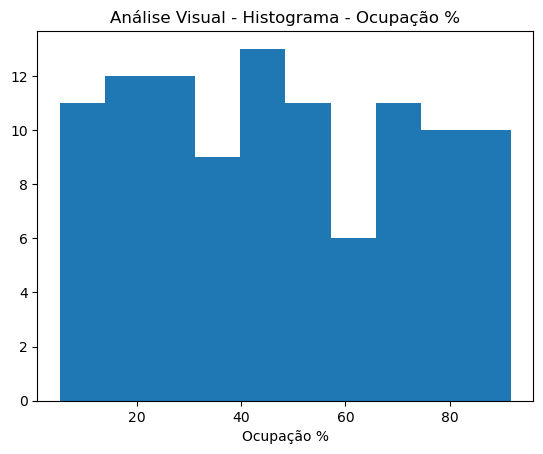

In [75]:
visualizacoes(dados_modelo_percentual_ocupacao, 'percentual_ocupacao', 'Ocupação %')

##### Modelo 2 

In [77]:
concentracao_valores(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

prejuizo_lucro
True     58
False    47
Name: count, dtype: int64


In [78]:
correlacao_modelos(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

Menores Valores
----------------------
campeonato_carioca              -0.403100
anunciou_poupar                 -0.363907
temperatura                     -0.341797
eliminatorio                    -0.289547
tipo_partida_volta              -0.254930
estado_adversario_RJ            -0.236182
time_adversario_Portuguesa-RJ   -0.221072
Name: prejuizo_lucro, dtype: float64
Maiores Valores
----------------------
prejuizo_lucro          1.000000
mes                     0.439681
rodada                  0.427245
campeonato_serie a      0.383712
tipo_partida_liga       0.310484
colocacao_adversario    0.242190
fase_fase de grupos     0.221612
Name: prejuizo_lucro, dtype: float64


##### Modelo 3

In [80]:
concentracao_valores(dados_modelo_resultado_partida, 'resultado_partida')

resultado_partida
 1    56
-1    27
 0    22
Name: count, dtype: int64


In [81]:
correlacao_modelos(dados_modelo_resultado_partida, 'resultado_partida')

Menores Valores
----------------------
time_adversario_Flamengo    -0.231833
fase_final                  -0.210428
estado_adversario_MT        -0.191337
time_adversario_Cuiabá-MT   -0.191337
dias_ultimo_jogo_casa       -0.173001
classico                    -0.157067
temperatura                 -0.152401
Name: resultado_partida, dtype: float64
Maiores Valores
----------------------
resultado_partida              1.000000
resultados_ultimo_jogo         0.533972
gols_botafogo_ultimos_jogos    0.242146
minuto                         0.214512
jogos_no_mes                   0.191769
dia_mes                        0.185826
fase_terceira fase             0.170445
Name: resultado_partida, dtype: float64


### Modelagem

#### Modelo 1

In [84]:
dados_modelo_percentual_ocupacao

,ano_campeonato,temperatura,jogos_no_mes,rodada,anunciou_poupar,classico,eliminatorio,desfalques,dia_semana,hora,...,fase_final,fase_final - taça rio,fase_liga,fase_oitavas-de-final,fase_quartas-de-final,fase_segunda fase,fase_semi-final,fase_semi-final - taça rio,fase_terceira fase,fase_unico
0,0.0,0.529412,0.391430,0.000000,False,True,True,0.833333,0.000000,0.784152,...,False,False,False,False,False,False,True,False,False,False
1,0.0,0.647059,0.000000,0.000000,False,False,False,0.416667,1.000000,0.197783,...,False,False,True,False,False,False,False,False,False,False
2,0.0,0.705882,0.000000,0.341657,False,False,False,0.583333,1.000000,0.000000,...,False,False,True,False,False,False,False,False,False,False
3,0.0,0.352941,0.391430,0.165300,False,False,True,0.666667,0.710560,1.000000,...,False,False,False,False,False,False,False,False,True,False
4,0.0,0.411765,0.617711,0.450239,False,False,False,0.416667,1.000000,0.441494,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.0,0.647059,0.000000,0.000000,False,True,True,0.000000,1.000000,0.197783,...,True,False,False,False,False,False,False,False,False,False
101,0.0,0.823529,0.391430,0.563012,True,False,False,0.416667,1.000000,0.197783,...,False,False,True,False,False,False,False,False,False,False
102,0.0,0.588235,0.617711,0.165300,False,False,True,0.333333,0.710560,1.000000,...,True,False,False,False,False,False,False,False,False,False
103,0.0,0.647059,0.000000,0.000000,False,False,False,0.250000,0.914043,0.197783,...,False,False,False,False,False,False,False,False,False,True


In [85]:
X = dados_modelo_percentual_ocupacao.drop(columns=['percentual_ocupacao']).copy()
y = dados_modelo_percentual_ocupacao[['percentual_ocupacao']]

In [86]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

##### Xgboost

In [88]:
parametros = tunning_hiperpametros_xgboost(XGBRegressor, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [89]:
model_xgboost = XGBRegressor(verbosity=0, learning_rate=0.01, max_depth=parametros[0], n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=parametros[1], gamma = parametros[2], subsample = parametros[3], colsample_bytree = parametros[4], 
                    scale_pos_weight = 1, reg_alpha= parametros[5], early_stopping_rounds=10, eval_metric='rmse')
model_xgboost.fit(X_train, y_train, eval_set=eval_set, verbose = 1)

[0]	validation_0-rmse:27.40616
[1]	validation_0-rmse:27.32126
[2]	validation_0-rmse:27.25340
[3]	validation_0-rmse:27.13745
[4]	validation_0-rmse:27.00051
[5]	validation_0-rmse:26.92050
[6]	validation_0-rmse:26.82286
[7]	validation_0-rmse:26.73477
[8]	validation_0-rmse:26.66966
[9]	validation_0-rmse:26.55522
[10]	validation_0-rmse:26.49180
[11]	validation_0-rmse:26.45538
[12]	validation_0-rmse:26.33624
[13]	validation_0-rmse:26.21052
[14]	validation_0-rmse:26.17687
[15]	validation_0-rmse:26.12836
[16]	validation_0-rmse:26.08302
[17]	validation_0-rmse:25.97263
[18]	validation_0-rmse:25.83583
[19]	validation_0-rmse:25.80734
[20]	validation_0-rmse:25.69109
[21]	validation_0-rmse:25.62549
[22]	validation_0-rmse:25.61979
[23]	validation_0-rmse:25.53466
[24]	validation_0-rmse:25.46661
[25]	validation_0-rmse:25.36041
[26]	validation_0-rmse:25.32582
[27]	validation_0-rmse:25.24443
[28]	validation_0-rmse:25.15979
[29]	validation_0-rmse:25.12439
[30]	validation_0-rmse:25.04968
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [90]:
model_xgboost.feature_importances_

array([0.        , 0.01114286, 0.00530266, 0.01008693, 0.01255134,
       0.01649815, 0.0031056 , 0.01575904, 0.0071096 , 0.0119738 ,
       0.00864123, 0.03669585, 0.01052956, 0.00635806, 0.00979359,
       0.02486444, 0.0095939 , 0.01235058, 0.01256394, 0.01004153,
       0.00973383, 0.07058526, 0.01281962, 0.01308761, 0.04435651,
       0.01060482, 0.01619858, 0.01014418, 0.0021509 , 0.00477823,
       0.00746908, 0.        , 0.002905  , 0.        , 0.00819811,
       0.00611059, 0.00134754, 0.00986772, 0.03761653, 0.00628576,
       0.00663726, 0.01580116, 0.01152812, 0.00298027, 0.        ,
       0.00187049, 0.00196681, 0.00818757, 0.00500674, 0.        ,
       0.00911171, 0.01398302, 0.0012451 , 0.        , 0.        ,
       0.00083897, 0.00280403, 0.04873678, 0.00533779, 0.01434291,
       0.01269689, 0.01377394, 0.        , 0.00746674, 0.00721667,
       0.01695852, 0.00437117, 0.00404555, 0.        , 0.        ,
       0.00197328, 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

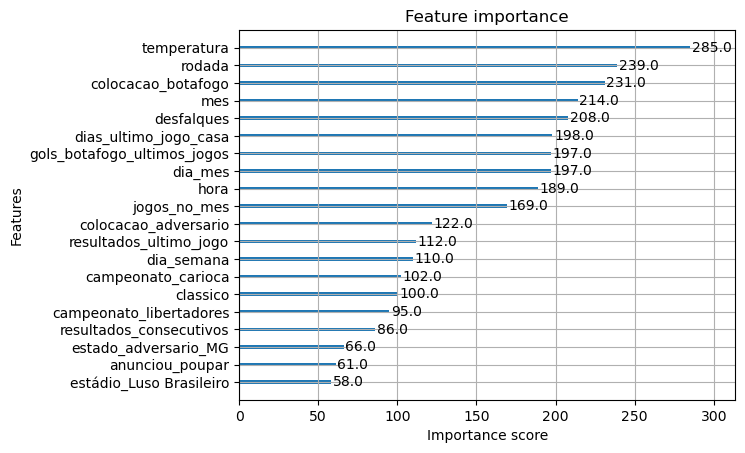

In [91]:
plot_importance(model_xgboost, max_num_features=20)

In [92]:
score = model_xgboost.score(X_train, y_train)  
score

0.9396739602088928

##### Catboost

In [94]:
parametros = tunning_hiperpametros_catboost(CatBoostRegressor, X_train, y_train)

Testando Variáveis: depth, min_data_in_leaf
Melhores valores para depth e min_data_in_leaf:  {'depth': 3, 'min_data_in_leaf': 1}
Testando Variáveis: learning_rate, iterations
Melhores valores para learning_rate e iterations:  {'iterations': 100, 'learning_rate': 0.01}
Testando Variáveis: subsample, colsample_bylevel
Melhores valores para subsample e colsample_bylevel:  {'colsample_bylevel': 0.6, 'subsample': 0.6}
-----------------------------


In [95]:
model_catboost = CatBoostRegressor(learning_rate=parametros[3], depth=parametros[0], min_data_in_leaf=parametros[1], iterations=parametros[2], random_state=1,  
                     subsample = parametros[4], colsample_bylevel=parametros[5], verbose=False)

model_catboost.fit(X_train, y_train, eval_set=eval_set, use_best_model=True, early_stopping_rounds=10)

In [96]:
model_catboost.feature_importances_

array([0.00000000e+00, 3.17681696e+00, 3.15931306e-01, 2.74176227e+00,
       3.60125626e+00, 2.22032596e+00, 1.30904435e-01, 1.16263685e+00,
       4.59091047e-01, 7.07163663e-01, 1.08278253e-01, 2.30967209e+01,
       1.98207244e+00, 1.47626637e-01, 4.68543284e-01, 1.16475188e+01,
       3.50855587e-01, 1.48899958e+00, 0.00000000e+00, 1.50312305e-01,
       4.54939269e-02, 3.53511139e+01, 2.02092412e-01, 1.59485229e+00,
       6.63945888e-02, 0.00000000e+00, 1.23566478e+00, 0.00000000e+00,
       3.25885945e-02, 0.00000000e+00, 5.70410083e-02, 1.44168728e-02,
       0.00000000e+00, 0.00000000e+00, 3.19931363e-01, 9.16010330e-02,
       0.00000000e+00, 3.15029284e-01, 1.74772778e-02, 7.67500162e-02,
       0.00000000e+00, 1.01159255e-01, 0.00000000e+00, 3.57827176e-02,
       0.00000000e+00, 3.81037706e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.64550984e-02, 2.91456491e-01,
       1.63726291e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

Text(0.5, 1.0, 'Feature Importance')

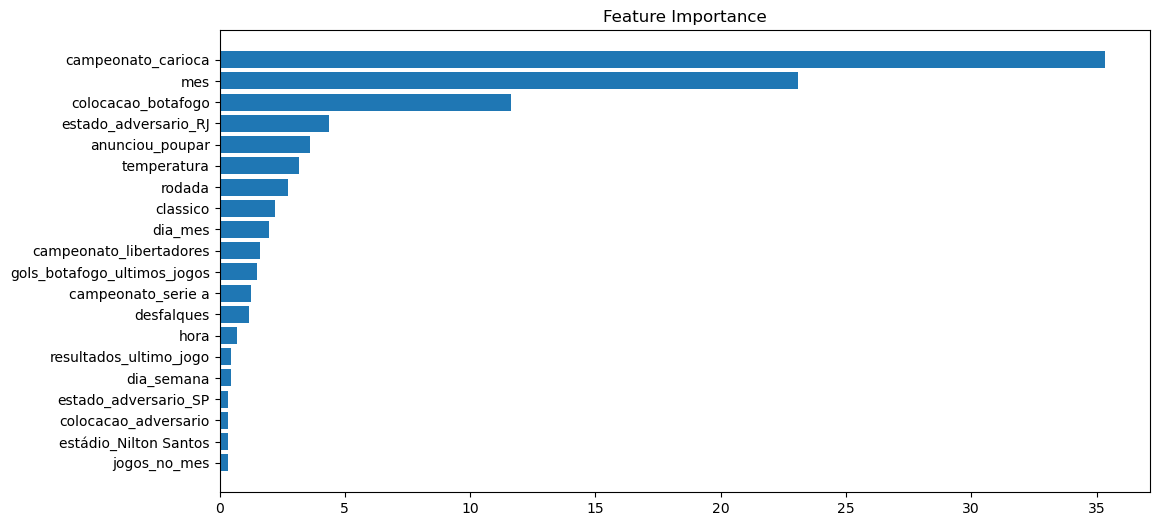

In [97]:
feature_importance = model_catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [98]:
score = model_catboost.score(X_train, y_train)  
score

0.34271649955663086

##### Decisao de qual modelo será

In [100]:
if model_catboost.score(X_train, y_train) > model_xgboost.score(X_train, y_train) :
    model = model_catboost
    modelo_escolhido = 'Catboost'
    dataset_resultados.loc[index_novo,'score_modelo_1'] = model_catboost.score(X_train, y_train)
else:
    model = model_xgboost
    modelo_escolhido = 'XGboost'
    dataset_resultados.loc[index_novo,'score_modelo_1'] = model_xgboost.score(X_train, y_train)

dataset_resultados.loc[index_novo,'modelo_1'] = modelo_escolhido
modelo_escolhido

'XGboost'

In [101]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

21

Text(0.5, 1.0, 'Previsão Ocupação')

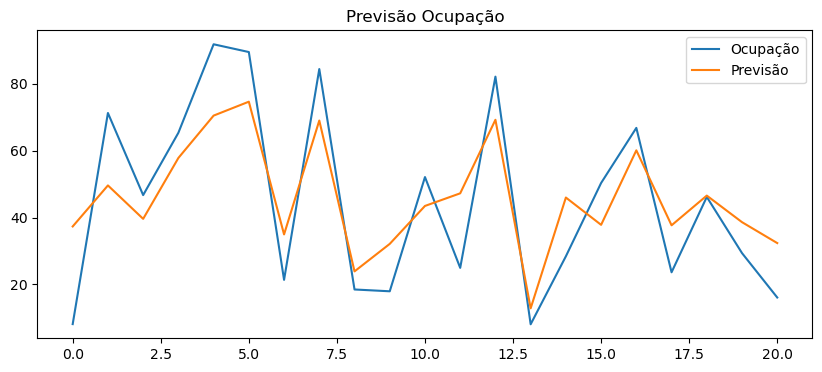

In [102]:
y_test = y_test.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test, label='Ocupação')
ax.plot(predictions, label='Previsão')
ax.legend()
ax.set_title("Previsão Ocupação")

In [103]:
rmse, mae = taxas_erro(y_test, predictions)
dataset_resultados.loc[index_novo,'rmse'] = rmse
dataset_resultados.loc[index_novo,'mae'] = mae

Erro médio quadrático:  14.753353971855981
Erro médio absoluto:  13.118095298040483


##### Previsões

In [105]:
dataset_previsao_modelo = dataset_previsao.drop(columns=['percentual_ocupacao', 'prejuizo_lucro', 'resultado_partida']
                                               ).copy().reset_index(drop=True).loc[:0]

In [106]:
model.predict(dataset_previsao_modelo)
dataset_resultados.loc[index_novo,'previsão_ocupacao'] = model.predict(dataset_previsao_modelo)[0]

#### Modelo 2

In [108]:
dados_modelo_prejuizo_lucro = dados_modelo_prejuizo_lucro[~dados_modelo_prejuizo_lucro['prejuizo_lucro'].isna() == True].reset_index(drop=True)

In [109]:
X = dados_modelo_prejuizo_lucro.drop(columns=['prejuizo_lucro']).copy()
y = dados_modelo_prejuizo_lucro[['prejuizo_lucro']]

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

##### XGBoost

In [112]:
parametros = tunning_hiperpametros_xgboost(XGBClassifier, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.1}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.7, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [113]:
model_xgboost = XGBClassifier(verbosity=0, learning_rate=0.01, max_depth=parametros[0], n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=parametros[1], gamma = parametros[2], subsample = parametros[3], colsample_bytree = parametros[4], 
                    scale_pos_weight = 1, reg_alpha= parametros[5], early_stopping_rounds=10, eval_metric='auc')

model_xgboost.fit(X_train, y_train, eval_set=eval_set, verbose = 1)

[0]	validation_0-auc:0.65455
[1]	validation_0-auc:0.71364
[2]	validation_0-auc:0.77727
[3]	validation_0-auc:0.84545
[4]	validation_0-auc:0.82727
[5]	validation_0-auc:0.83636
[6]	validation_0-auc:0.84545
[7]	validation_0-auc:0.83636
[8]	validation_0-auc:0.85455
[9]	validation_0-auc:0.85455
[10]	validation_0-auc:0.85455
[11]	validation_0-auc:0.87273
[12]	validation_0-auc:0.85455
[13]	validation_0-auc:0.83636
[14]	validation_0-auc:0.83636
[15]	validation_0-auc:0.83636
[16]	validation_0-auc:0.85455
[17]	validation_0-auc:0.86364
[18]	validation_0-auc:0.85455
[19]	validation_0-auc:0.86364
[20]	validation_0-auc:0.88182
[21]	validation_0-auc:0.87273
[22]	validation_0-auc:0.89091
[23]	validation_0-auc:0.87273
[24]	validation_0-auc:0.88182
[25]	validation_0-auc:0.90000
[26]	validation_0-auc:0.90000
[27]	validation_0-auc:0.90000
[28]	validation_0-auc:0.90000
[29]	validation_0-auc:0.89091
[30]	validation_0-auc:0.90000
[31]	validation_0-auc:0.90000
[32]	validation_0-auc:0.89091
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None, ...)

In [114]:
model_xgboost.feature_importances_

array([0.        , 0.05840071, 0.01848289, 0.06087902, 0.06127374,
       0.        , 0.05363018, 0.03185852, 0.03597577, 0.04028177,
       0.        , 0.10622777, 0.04211139, 0.0376279 , 0.03376681,
       0.0527877 , 0.02277454, 0.02493571, 0.        , 0.03128532,
       0.        , 0.09631133, 0.        , 0.        , 0.        ,
       0.        , 0.061983  , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05624495,
       0.        , 0.03209543, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04106549, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

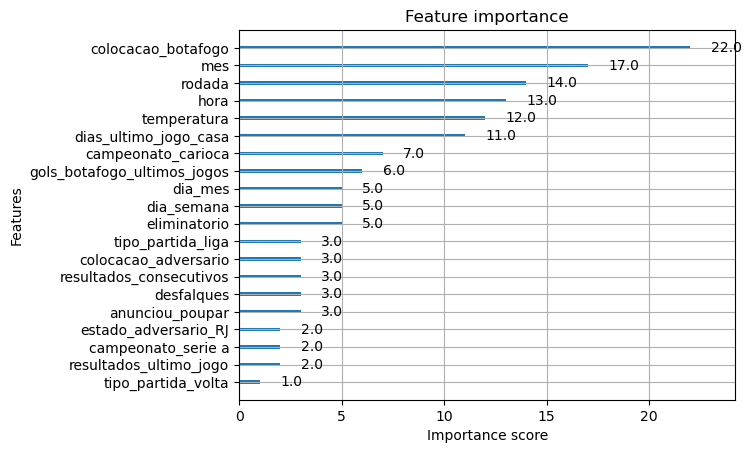

In [115]:
plot_importance(model_xgboost, max_num_features=20)

In [116]:
score = model_xgboost.score(X_train, y_train)  
score

0.6904761904761905

##### Catboost

In [118]:
parametros = tunning_hiperpametros_catboost(CatBoostRegressor, X_train, y_train)

Testando Variáveis: depth, min_data_in_leaf
Melhores valores para depth e min_data_in_leaf:  {'depth': 3, 'min_data_in_leaf': 1}
Testando Variáveis: learning_rate, iterations
Melhores valores para learning_rate e iterations:  {'iterations': 100, 'learning_rate': 0.01}
Testando Variáveis: subsample, colsample_bylevel
Melhores valores para subsample e colsample_bylevel:  {'colsample_bylevel': 0.6, 'subsample': 0.6}
-----------------------------


In [119]:
model_catboost = CatBoostClassifier(learning_rate=parametros[3], depth=parametros[0], min_data_in_leaf=parametros[1], iterations=parametros[2], random_state=1,  
                     subsample = parametros[4], colsample_bylevel=parametros[5], verbose=False, bootstrap_type='Bernoulli')

model_catboost.fit(X_train, y_train, eval_set=eval_set, use_best_model=True, early_stopping_rounds=10)

In [120]:
model_catboost.feature_importances_

array([0.00000000e+00, 3.86955451e+00, 7.42258860e-01, 1.05520020e+01,
       4.53690042e+00, 3.28106046e+00, 5.88965038e+00, 1.68855830e+00,
       1.80980874e+00, 4.17844726e+00, 9.15723205e-01, 2.03960519e+01,
       1.26088389e+00, 1.05337501e+00, 5.50882134e-01, 4.05024756e+00,
       9.56744517e-01, 2.29983153e+00, 1.11555620e+00, 1.40348084e+00,
       1.86130501e-02, 9.72205498e+00, 7.99464795e-01, 3.86719978e+00,
       0.00000000e+00, 1.25950761e-01, 3.85451862e+00, 1.66625088e-01,
       1.67547317e-02, 0.00000000e+00, 0.00000000e+00, 1.58773856e-01,
       0.00000000e+00, 0.00000000e+00, 9.22617458e-01, 1.56698069e-01,
       6.28849069e-02, 1.53080989e-01, 0.00000000e+00, 2.06616093e+00,
       1.54699941e-01, 6.62407478e-01, 3.91022603e-02, 2.19243010e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.31248875e-01, 0.00000000e+00,
       2.71682148e-02, 0.00000000e+00, 0.00000000e+00, 8.64983120e-02,
      

Text(0.5, 1.0, 'Feature Importance')

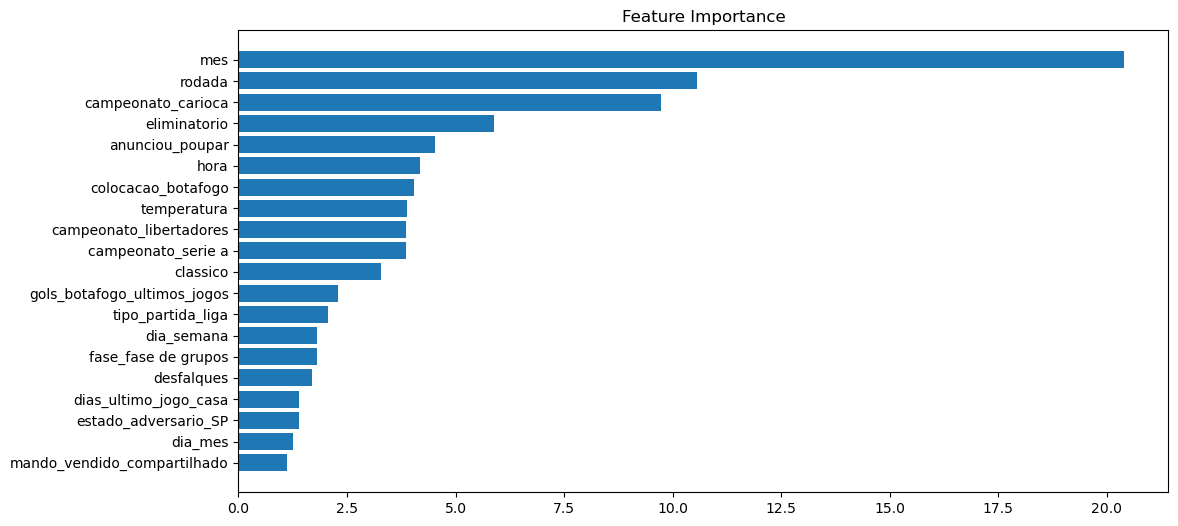

In [121]:
feature_importance = model_catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [122]:
score = model_catboost.score(X_train, y_train)  
score

0.8452380952380952

##### Decisao de qual modelo será

In [124]:
if model_catboost.score(X_train, y_train) > model_xgboost.score(X_train, y_train) :
    model = model_catboost
    modelo_escolhido = 'Catboost'
    dataset_resultados.loc[index_novo,'score_modelo_2'] = model_catboost.score(X_train, y_train)
else:
    model = model_xgboost
    modelo_escolhido = 'XGboost'
    dataset_resultados.loc[index_novo,'score_modelo_2'] = model_xgboost.score(X_train, y_train)
dataset_resultados.loc[index_novo,'modelo_2'] = modelo_escolhido
modelo_escolhido

'Catboost'

In [125]:
y_pred = model.predict(X_test)
if modelo_escolhido == 'Catboost':
    predictions = [int(value) for value in y_pred]
else:
    predictions = [round(value, 2) for value in y_pred]
len(predictions)

21

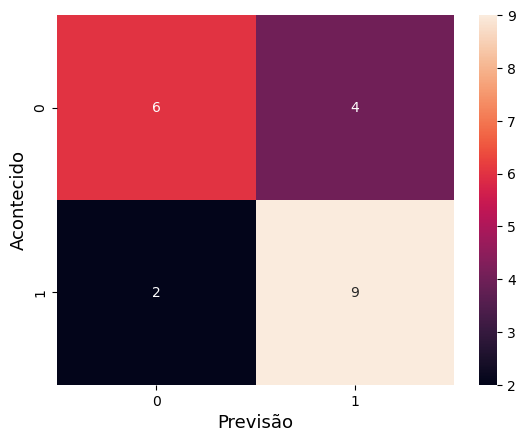

In [126]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [127]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.75      0.60      0.67        10
        True       0.69      0.82      0.75        11

    accuracy                           0.71        21
   macro avg       0.72      0.71      0.71        21
weighted avg       0.72      0.71      0.71        21



In [128]:
acc = accuracy_score(y_test, predictions)
dataset_resultados.loc[index_novo,'acurácia_modelo_2'] = acc

##### Previsões

In [130]:
model.predict(dataset_previsao_modelo)
if model.predict(dataset_previsao_modelo)[0] == True:
    dataset_resultados.loc[index_novo,'previsão_prejuizo_lucro'] = 1
else:
    dataset_resultados.loc[index_novo,'previsão_prejuizo_lucro'] = 0

#### Modelo 3

In [132]:
X = dados_modelo_resultado_partida.drop(columns=['resultado_partida']).copy()
y = dados_modelo_resultado_partida[['resultado_partida']]

In [133]:
y.loc[y[y['resultado_partida'] == -1].index, 'resultado_partida'] = 2

In [134]:
y['resultado_partida'] = y['resultado_partida'].astype(int)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

##### XGboost

In [137]:
parametros = tunning_hiperpametros_xgboost(XGBClassifier, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [138]:
model_xgboost = XGBClassifier(verbosity=0, learning_rate=0.01, max_depth=parametros[0], n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=parametros[1], gamma = parametros[2], subsample = parametros[3], colsample_bytree = parametros[4], 
                    scale_pos_weight = 1, reg_alpha= parametros[5], early_stopping_rounds=10, eval_metric='auc')

model_xgboost.fit(X_train, y_train, eval_set=eval_set, verbose = 1)

[0]	validation_0-auc:0.89661
[1]	validation_0-auc:0.81387
[2]	validation_0-auc:0.86238
[3]	validation_0-auc:0.89125
[4]	validation_0-auc:0.92011
[5]	validation_0-auc:0.91926
[6]	validation_0-auc:0.90353
[7]	validation_0-auc:0.88827
[8]	validation_0-auc:0.89673
[9]	validation_0-auc:0.89290
[10]	validation_0-auc:0.88444
[11]	validation_0-auc:0.89720
[12]	validation_0-auc:0.90102
[13]	validation_0-auc:0.88827


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None, ...)

In [139]:
model_xgboost.feature_importances_

array([0.        , 0.04679729, 0.02714416, 0.03142215, 0.02719182,
       0.        , 0.01035113, 0.03084299, 0.03035498, 0.0358968 ,
       0.01916035, 0.05853233, 0.04470766, 0.03821365, 0.08280744,
       0.03585866, 0.05129103, 0.05388421, 0.        , 0.05690185,
       0.        , 0.01326   , 0.        , 0.        , 0.        ,
       0.        , 0.01489382, 0.04048676, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0165766 ,
       0.        , 0.        , 0.        , 0.        , 0.03950308,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02239413, 0.02033372, 0.        , 0.        , 0.        ,
       0.        , 0.02849621, 0.02612885, 0.        , 0.        ,
       0.02667934, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

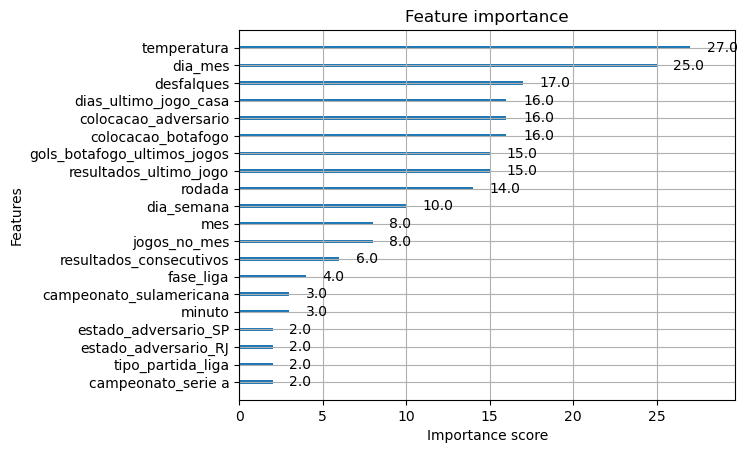

In [140]:
plot_importance(model_xgboost, max_num_features=20)

In [141]:
score = model_xgboost.score(X_train, y_train)  
score

0.7976190476190477

##### Catboost

In [143]:
parametros = tunning_hiperpametros_catboost(CatBoostRegressor, X_train, y_train)

Testando Variáveis: depth, min_data_in_leaf
Melhores valores para depth e min_data_in_leaf:  {'depth': 3, 'min_data_in_leaf': 1}
Testando Variáveis: learning_rate, iterations
Melhores valores para learning_rate e iterations:  {'iterations': 100, 'learning_rate': 0.01}
Testando Variáveis: subsample, colsample_bylevel
Melhores valores para subsample e colsample_bylevel:  {'colsample_bylevel': 0.6, 'subsample': 0.6}
-----------------------------


In [144]:
model_catboost = CatBoostClassifier(learning_rate=parametros[3], depth=parametros[0], min_data_in_leaf=parametros[1], iterations=parametros[2], random_state=1,  
                     subsample = parametros[4], colsample_bylevel=parametros[5], verbose=False, bootstrap_type='Bernoulli')

model_catboost.fit(X_train, y_train, eval_set=eval_set, use_best_model=True, early_stopping_rounds=10)

In [145]:
model_catboost.feature_importances_

array([0.00000000e+00, 4.97885040e+00, 3.84146157e+00, 2.34098853e+00,
       0.00000000e+00, 1.04453961e+00, 5.29567253e-01, 3.23459037e+00,
       2.04420969e+00, 1.50734548e+00, 3.24181604e+00, 6.93976190e+00,
       1.06758560e+01, 3.26121569e+00, 3.05543030e+01, 4.55006328e+00,
       4.52414734e+00, 4.79121692e+00, 1.82766412e-01, 4.15982555e+00,
       1.27178960e-02, 2.07611230e-01, 4.52394512e-02, 4.16112889e-04,
       4.22650125e-03, 0.00000000e+00, 7.28305624e-01, 1.97276811e+00,
       1.53268492e-02, 0.00000000e+00, 0.00000000e+00, 8.15146872e-03,
       2.72517975e-02, 0.00000000e+00, 1.77634815e-01, 1.32166473e-01,
       0.00000000e+00, 1.87986362e-01, 1.86364099e-02, 7.63886670e-01,
       4.46533539e-02, 8.16682632e-02, 1.02473559e-01, 5.72171772e-02,
       0.00000000e+00, 2.49543178e-03, 0.00000000e+00, 6.20605503e-02,
       1.06099317e-02, 0.00000000e+00, 0.00000000e+00, 7.44168091e-02,
       2.91682688e-02, 1.06050702e-02, 0.00000000e+00, 7.57938153e-03,
      

Text(0.5, 1.0, 'Feature Importance')

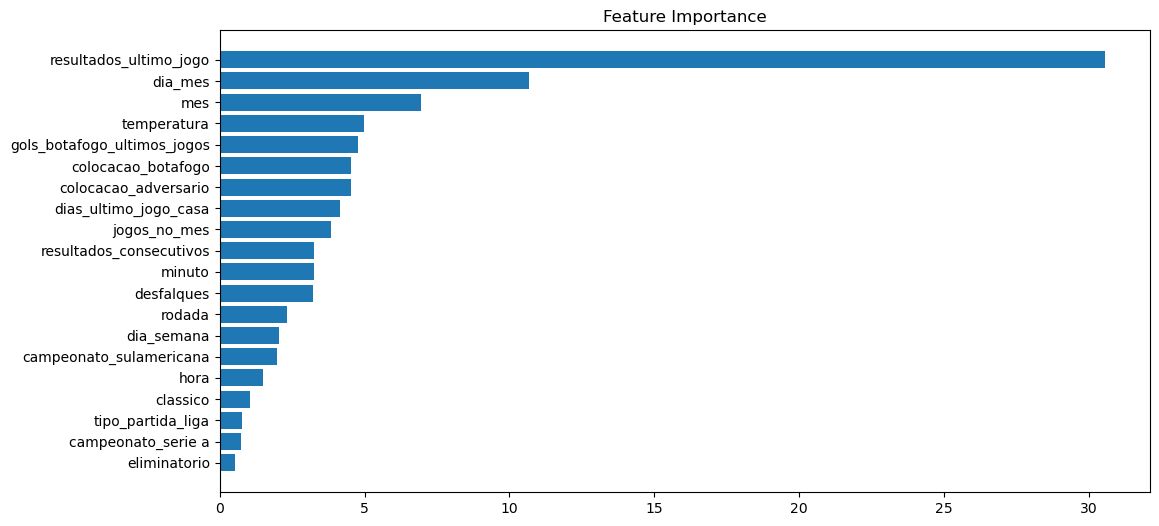

In [146]:
feature_importance = model_catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [147]:
score = model_catboost.score(X_train, y_train)  
score

0.5357142857142857

##### Decisao de qual modelo será

In [149]:
if model_catboost.score(X_train, y_train) > model_xgboost.score(X_train, y_train) :
    model = model_catboost
    modelo_escolhido = 'Catboost'
    dataset_resultados.loc[index_novo,'score_modelo_3'] = model_catboost.score(X_train, y_train)
else:
    model = model_xgboost
    modelo_escolhido = 'XGboost'
    dataset_resultados.loc[index_novo,'score_modelo_3'] = model_xgboost.score(X_train, y_train)

dataset_resultados.loc[index_novo,'modelo_3'] = modelo_escolhido
modelo_escolhido

'XGboost'

In [150]:
y_pred = model.predict(X_test)
if modelo_escolhido == 'Catboost':
    predictions = [int(value) for value in y_pred]
else:
    predictions = [round(value, 2) for value in y_pred]
len(predictions)

21

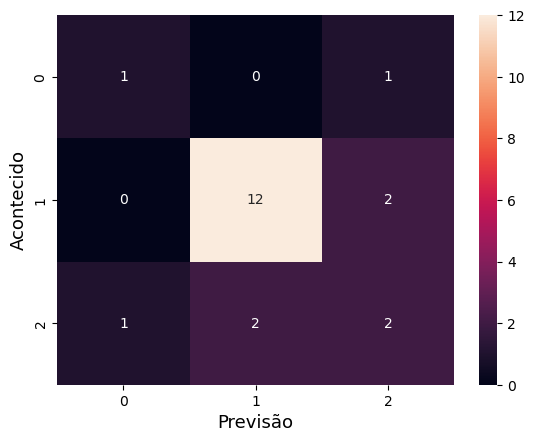

In [151]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [152]:
print(classification_report(y_test, predictions))
acc = accuracy_score(y_test, predictions)
dataset_resultados.loc[index_novo,'acurácia_modelo_2'] = acc

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.86      0.86      0.86        14
           2       0.40      0.40      0.40         5

    accuracy                           0.71        21
   macro avg       0.59      0.59      0.59        21
weighted avg       0.71      0.71      0.71        21



##### Previsões

In [154]:
model.predict(dataset_previsao_modelo)
dataset_resultados.loc[index_novo,'previsão_resultado_partida'] = model.predict(dataset_previsao_modelo)[0]

In [155]:
dataset_resultados.to_excel('botafogo_valores_previstos.xlsx', index=False)